# CPPI and Monte Carlo Simulation 

<p>    
Constant Proportion Portfolio Insurance (CPPI) is a strategy that can be used to ensure downside protection through dynamic allocation to a risky and a safe asset. For instance, if we have a 100K portfolio, of which the investor decides 80K is the floor value. If portfolio falls to 80K in value, the investor would move assets to cash to preserve capital. If one decides that 30% is the maximum crash possibility, the multiplier will be 1/0.3 = 3.33. Based on this, the investor would allocate 3.33*(100K - 80K) = 66.6% into the risky asset and the remainder into cash or the conservative asset.
    
CPPI is a popular asset allocation strategy. Markowitz's Mean-Variance analysis is very sensitive to parameter estimates so CPPI is gaining popularity. Using CPPI, we will see if the floor value is breached.

Finally, we will use Monte Carlo simulation to generate thousands of stock price movements and see if any of them breach the CPPI strategy.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# This dataset is from the Ken French website and has data on 17 different industries from 1926 till 2020.
# However, I have only analyzed 2 industries to showcase/ explain the concept of CPPI.
ind = pd.read_csv("C:/Users/aleem/Documents/Quant finance/Excel files - online learning/Practice Datasets/17_Industry_Portfolios.csv", 
                     header = 0, index_col = 0, parse_dates = True)
ind = ind/100
ind.index = pd.to_datetime(ind.index, format = '%Y%m').to_period('M')
ind.columns = ind.columns.str.strip()
ind.head()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
1926-07,0.0048,0.0378,-0.0141,0.0602,-0.0162,0.0846,0.0142,0.0231,0.0407,0.0877,0.0379,0.1743,0.0184,0.0704,0.0013,0.0037,0.0122
1926-08,0.0291,0.0069,0.0360,0.0015,-0.0196,0.0570,0.0584,0.0433,0.0217,-0.0556,0.0235,0.0396,0.0457,-0.0169,-0.0068,0.0446,0.0311
1926-09,0.0120,0.0110,-0.0368,0.0026,0.0024,0.0548,0.0121,-0.0006,0.0015,-0.0413,-0.0065,0.0557,0.0030,0.0204,0.0021,-0.0123,0.0182
1926-10,-0.0306,-0.0079,-0.0102,0.0037,-0.0607,-0.0476,0.0069,-0.0479,-0.0385,-0.0513,-0.0329,-0.0829,-0.0292,-0.0263,-0.0226,-0.0516,-0.0088
1926-11,0.0637,0.0438,-0.0001,0.0222,-0.0195,0.0527,0.0463,0.0245,0.0386,0.0357,0.0454,-0.0028,0.0218,0.0371,0.0644,0.0224,0.0138


In [82]:
def cppi(risky_r, start = 100000, floor = 0.8, riskfree_r = 0.01, m = 3.33):
    num_steps = len(risky_r.index)
    account_value = start
    floor_value = floor * start
    safe_r = pd.DataFrame().reindex_like(risky_r)
    safe_r[:] = 0.01/12
    acc_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    risky_weight_history = pd.DataFrame().reindex_like(risky_r)
    for step in range(num_steps):
        cushion = (account_value - floor_value)/account_value
        risky_w = m * cushion
        risky_w = np.minimum(1, risky_w)
        risky_w = np.maximum(0, risky_w)
        safe_w = 1 - risky_w
        risky_alloc = risky_w * account_value
        safe_alloc = safe_w * account_value
        account_value = (risky_alloc * (1 + risky_r.iloc[step])) + (safe_alloc * (1 + safe_r.iloc[step]))
        cushion_history.iloc[step] = cushion
        acc_history.iloc[step] = account_value
        risky_weight_history.iloc[step] = risky_w
    risky_wealth = start * (1+risky_r).cumprod()
    result = {
        "Risky Wealth": risky_wealth,
        "Wealth":acc_history,
        "m": m,
        "Cushion history": cushion_history,
        "start": start,
        "floor": floor,
        "Risky alloc": risky_weight_history,
        "risky_r": risky_r,
        "safe_r": safe_r
    }
    return result

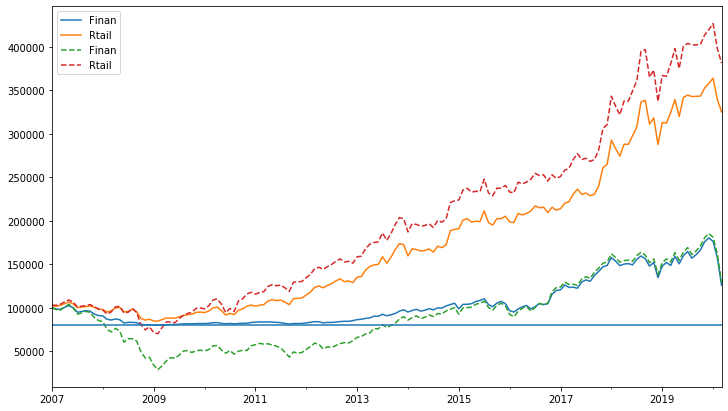

In [92]:
# The red dotted line is the pure risky version of Retail, while the orange one is a combination of risky plus the risk-free asset.
# The green dotted line is the pure risky version of Finance, while the blue one is a combination of risky plus the risk-free asset.
# The flat blue line at the 80K range is the floor value
# Looking at the graphs below, the Finance industry (pure risky asset) has quite a bit of volatility (21.6% annual), thats why it has gone under the 80K floor value.
# Retail is less volatile (14.4% annual) and therefore only breaches for a short time.

# However, the mix of risky and safe asset never breaches the 80K threshold for both Finance and Retail. 
# Once the portfolio goes down from the 100k value towards the 80k threshold, the CPPI strategy automatically allocates more money from the risky assets towards the risk free asset until the value goes up again.
# This is the beauty of CPPI.

data = ind["2007":][["Finan", "Rtail"]]
results = cppi(data)
ax = results["Wealth"].plot(figsize=(12,7))
results["Risky Wealth"].plot(ax=ax, style="--")
ax.axhline(y = 80000)

In [100]:
stdev = data.std() * np.sqrt(12)
n_months = data.shape[0]
monthly_returns = (1 + data).prod() ** (1/n_months)
ann_returns = monthly_returns ** 12
final = pd.concat([stdev, ann_returns], axis = 'columns')
final.columns = ["Ann stdev", "Ann Return"]
final

,Ann stdev,Ann Return
Finan,0.216496,1.019787
Rtail,0.144267,1.106336


### Now lets use Monte Carlo to simulate different prices and see if these prices breach the 80K threshold

## Use this formula
# $ \frac{S_{t+dt} - S_t}{S_t} = \mu.dt + \sigma.\sqrt{dt}.\xi_t$ 

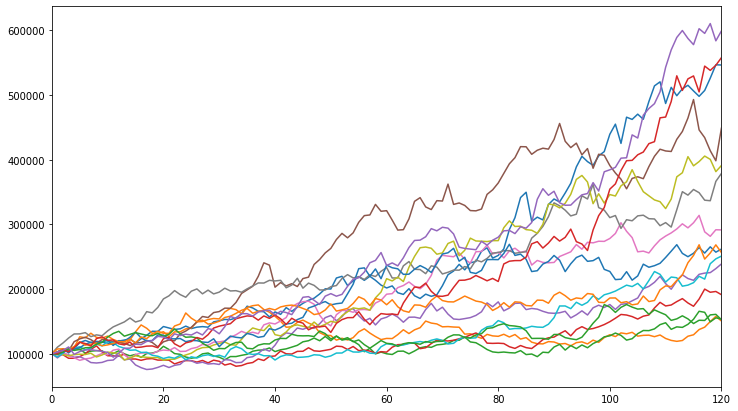

In [182]:
# Simulate a graph showing 15 different possible future realizations of a stock price

def gbm(num_years = 10, num_scenarios=1000, mu=0.1, sigma=0.14, periods_per_year=12, s_0=100000, prices = True):
    dt = 1/periods_per_year
    num_steps = int(num_years*periods_per_year) + 1
    returns = np.random.normal(loc=(mu*dt+1), scale=(sigma*np.sqrt(dt)), size=(num_steps, num_scenarios))
    returns[0] = 1
    prices = s_0*pd.DataFrame(returns).cumprod() if prices else returns - 1
    return prices
gbm(num_scenarios = 15).plot(legend = False, figsize = (12,7))

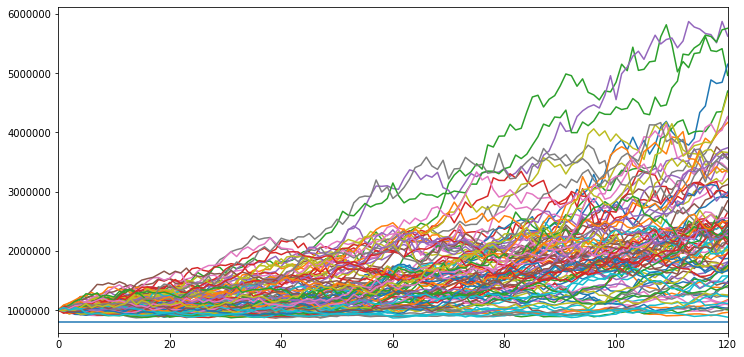

In [196]:
# We have an interactive way of checking out the graph now. We can play around with the widgets to analyze.
# As mu increases, the graph shifts upwards. 
# As sigma increases, the simulated prices grow further apart due to increased volatility
# As m increases, that means we are putting in more money towards our risky asset and hence our return and volatility will increase
# As the riskfree_rate increases, our graph will shift upwards as we are getting additional returns with no added risk.

# We see no violations even when we simulate multiple future prices for an asset similar to the one in the above CPPI example with an average return of 10% and std = 14% yearly

import ipywidgets as widgets
from IPython.display import display

def mc_cppi(num_scenarios=100, mu=0.1, sigma=0.14, m=3.33, floor=0.8, riskfree_r=0.01):
    start = 1000000
    simulated_rets = gbm(num_scenarios=num_scenarios, mu=mu, sigma=sigma, prices=False, num_years = 10, periods_per_year=12, s_0 = start)
    risky_r = pd.DataFrame(simulated_rets)
    cppi_data = cppi(risky_r=risky_r, riskfree_r=riskfree_r, m=m, start=start, floor=floor)
    wealth = cppi_data["Wealth"]
    ax = wealth.plot(legend=False, figsize=(12, 6))
    ax.axhline(y=start*floor)
    return ax

mc_cppi()

In [197]:
# Unfotunately, GitHub does not have the option of displaying the widgets. You can take a look at widget.pdf in this repository to see what it looks like
# Note: It is the same graph as the one above, but with the widgets.

def mc_cppi(num_scenarios=100, mu=0.1, sigma=0.14, m=3.33, floor=0.8, riskfree_r=0.01):
    start = 1000000
    simulated_rets = gbm(num_scenarios=num_scenarios, mu=mu, sigma=sigma, prices=False, num_years = 10, periods_per_year=12, s_0 = start)
    risky_r = pd.DataFrame(simulated_rets)
    cppi_data = cppi(risky_r=risky_r, riskfree_r=riskfree_r, m=m, start=start, floor=floor)
    wealth = cppi_data["Wealth"]
    ax = wealth.plot(legend=False, figsize=(12, 6))
    ax.axhline(y=start*floor)

cppi_widgets = widgets.interactive(mc_cppi, 
                                   num_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=25), 
                                   mu = (0, .2, .01),
                                   sigma = (0, .30, .05),
                                   floor = (0, 2, .1),
                                   m = (1, 5, .5),
                                   riskfree_r = (0, .05, .01))
display(cppi_widgets)

interactive(children=(IntSlider(value=25, description='num_scenarios', max=1000, min=1, step=5), FloatSlider(v…